##### To run the below code, please use pip:
###### pipenv install - to install all the needed libraries and dependencies
###### pipenv shell - to choose this virtual environment
###### pipenv --rm - to remove the virtual environment/kernel once done

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from scipy.stats import norm
%matplotlib inline

###### First, I'm loading the csv file with a specified encoding since it appears there were pound symbols in the file.

In [2]:
online_retail = pd.read_csv("./Online_Retail - Original.csv", encoding="ISO-8859-1")

###### Now I'm checking how does the table look like

In [3]:
online_retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France


###### Also checking some basic details about the table

In [4]:
online_retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
online_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


##### Cleaning the data

###### Here, I'm checking if there are any NaN values in each column

In [6]:
print(online_retail[online_retail["Description"].isna()])
print(online_retail[online_retail["StockCode"].isna()])
print(online_retail[online_retail["InvoiceNo"].isna()])
print(online_retail[online_retail["Quantity"].isna()])
print(online_retail[online_retail["InvoiceDate"].isna()])
print(online_retail[online_retail["UnitPrice"].isna()])
print(online_retail[online_retail["Country"].isna()])


       InvoiceNo StockCode Description  Quantity    InvoiceDate  UnitPrice   
622       536414     22139         NaN        56  12/1/10 11:52        0.0  \
1970      536545     21134         NaN         1  12/1/10 14:32        0.0   
1971      536546     22145         NaN         1  12/1/10 14:33        0.0   
1972      536547     37509         NaN         1  12/1/10 14:33        0.0   
1987      536549    85226A         NaN         1  12/1/10 14:34        0.0   
...          ...       ...         ...       ...            ...        ...   
535322    581199     84581         NaN        -2  12/7/11 18:26        0.0   
535326    581203     23406         NaN        15  12/7/11 18:31        0.0   
535332    581209     21620         NaN         6  12/7/11 18:35        0.0   
536981    581234     72817         NaN        27  12/8/11 10:33        0.0   
538554    581408     85175         NaN        20  12/8/11 14:06        0.0   

        CustomerID         Country  
622            NaN  United

###### These lines of code take care of the entire table cleaning

In [7]:
##I start by assigning the original dataframe copy to a new variable
clean_data = online_retail.copy()

##Once done, I'm getting rid of every leading and trailing characters in each string column that shouldn't be there 
for c in clean_data.columns:
    clean_data[c] = clean_data[c].map(lambda x: x.strip(" |,|.|*") if type(x) == str else x)

##Now, I'm checking how many items there are with quantity below 1, then I'm checking what is the reason behind it,
##if there is any connection in the data regarding negative quantities. It appears that these may be returns or canceled
##orders. I'm deleting them from the dataframe as in this analysis I'm only checking original orders without any 
##modifications to them. However, it would be a good idea in future anaylsis to check these negative records and 
##adjust the data accordingly. 
clean_data[clean_data["Quantity"] < 1]
clean_data[(clean_data["CustomerID"] == 17315.0) & (clean_data["Description"] == "36 PENCILS TUBE RED RETROSPOT")]
clean_data = clean_data.drop(clean_data[clean_data["Quantity"] < 1].index)

##Next I'm checking these rows that have a price lower than the smallest possible coin denomination. 
##After checking, it appeared that the dataframe not only cointains items, but also other transactions, like
##error, debt adjustments, fees, generally things that are not considered items or that are not "sold"
##by an online retail shop, but more like accounting transactions. 
clean_data[clean_data["UnitPrice"] < 0.01]["Description"].unique()

##However, not all rows with that unit price were such transactions. Some of them were actually items that
##had no unit price, which shouldn't be possible in a shop. That's why here, I've checked what were the prices
##of one of such items.
clean_data[clean_data["Description"] == "CHILDRENS GARDEN GLOVES BLUE"]["UnitPrice"].unique()


##After determining that it is possible to fill these 0 values with medians of these products values throughout the
##time, I've decided to do exactly that. 
missing_medians = clean_data[clean_data["Description"].isin(clean_data[clean_data["UnitPrice"] < 0.01]["Description"])
                             ].groupby("Description")[["UnitPrice"]].median()

merge = clean_data.loc[(clean_data["Description"].isin(missing_medians.index)) & (clean_data["UnitPrice"] < 0.01)
               ].merge(missing_medians, how="left", on="Description")

clean_data.loc[(clean_data["Description"].isin(missing_medians.index)) & (clean_data["UnitPrice"] < 0.01), "UnitPrice"
               ] = merge["UnitPrice_y"].values


##Once the 0 values have been filled with medians, I've deleted all the rest of the items that still had no value. 
##That's because there is no other data to fill these prices with and almost all of them are the previously mentioned
##accounting transactions or records like "smashed, error, found" etc.
clean_data.drop(clean_data[clean_data["UnitPrice"] < 0.01].index, inplace=True)


##To make sure that all of such records have been deleted from the dataframe, I'm again scanning the description column
##and deleting these rows that may contain the following words.
items_to_delete = clean_data[clean_data["Description"].str.contains(
    "Error|Incorrect|Adjust|Broken|Fix|Return", case=False)]

clean_data.drop(items_to_delete.index, inplace=True)

##Then, I'm changing the description to show as Titles and not as Uppercases
clean_data["Description"] = clean_data["Description"].str.title()

##Next, I'm changing the data type of date to datetime and adding some additional columns based on those dates. 
clean_data["InvoiceDate"] = pd.to_datetime(clean_data["InvoiceDate"])

clean_data["Year"] = clean_data["InvoiceDate"].dt.year
clean_data["Month"] = clean_data["InvoiceDate"].dt.month_name()
clean_data["Day"] = clean_data["InvoiceDate"].dt.day

##Here, I'm adding another additional column with the quantity and unit price multiplied to get the order sum.
clean_data["OrderSum"] = clean_data["Quantity"] * clean_data["UnitPrice"]

##Next, I'm changing the inovice numbers to numeric as we only have numeric values there. 
clean_data["InvoiceNo"] = pd.to_numeric(clean_data["InvoiceNo"])

##Also, I'm changing the customer id to Int64, as in the dataframe they were showing as decimals, because
##we have some NaN values in that column. 
clean_data["CustomerID"] = clean_data["CustomerID"].astype("Int64")

##Then, I delete the unspecified country, as this column will be one of the key columns of my analysis and 
##unspecified country doesn't give us any information. Additionally, these rows are a really small part
##of the entire dataframe, hence they do not impact our data. 
clean_data["Country"].unique()
clean_data = clean_data[~(clean_data["Country"] == "Unspecified")]

##Next, I change the country names to more recognizable ones
clean_data.loc[clean_data["Country"] == "EIRE", "Country"] = "Ireland"
clean_data.loc[clean_data["Country"] == "RSA", "Country"] = "Republic of South Africa"

##Finally, I'm changing the order of the columns and resetting the index.
clean_data = clean_data[["InvoiceNo", "InvoiceDate", "Year", "Month", "Day", "StockCode", "Description", 
                         "Quantity", "UnitPrice", "OrderSum", "CustomerID", "Country"]]

clean_data.reset_index(inplace=True, drop=True)

C:\Users\rrojo\AppData\Local\Temp\ipykernel_11640\3881913251.py:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clean_data["InvoiceDate"] = pd.to_datetime(clean_data["InvoiceDate"])


In [8]:
##After doing all of the cleaning, I'm assigning that dataframe to another variable, just to have the previous variable
##as a backup.
final_df = clean_data.copy()

In [9]:
final_df

,InvoiceNo,InvoiceDate,Year,Month,Day,StockCode,Description,Quantity,UnitPrice,OrderSum,CustomerID,Country
0,536365,2010-12-01 08:26:00,2010,December,1,85123A,White Hanging Heart T-Light Holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,2010,December,1,71053,White Metal Lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,2010,December,1,84406B,Cream Cupid Hearts Coat Hanger,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,2010,December,1,84029G,Knitted Union Flag Hot Water Bottle,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,2010,December,1,84029E,Red Woolly Hottie White Heart,6,3.39,20.34,17850,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...
530069,581587,2011-12-09 12:50:00,2011,December,9,22613,Pack Of 20 Spaceboy Napkins,12,0.85,10.20,12680,France
530070,581587,2011-12-09 12:50:00,2011,December,9,22899,Children'S Apron Dolly Girl,6,2.10,12.60,12680,France
530071,581587,2011-12-09 12:50:00,2011,December,9,23254,Childrens Cutlery Dolly Girl,4,4.15,16.60,12680,France
530072,581587,2011-12-09 12:50:00,2011,December,9,23255,Childrens Cutlery Circus Parade,4,4.15,16.60,12680,France


##### Analisys & Visualizations - I'm approaching the values in this dataframe as if it was our population. I will include a bonus part where I create QQ plots and do some statistic calculations by approaching some of the data as a sample of the population

###### Base dataframe - Grouped the df by Invoice No and created some custom aggregates

In [10]:
final_df_by_invoice = final_df.groupby("InvoiceNo").agg(
    NoofItems = pd.NamedAgg("Quantity", "sum"),
    OrderTotal = pd.NamedAgg("OrderSum", "sum"),
    InvoiceDate = pd.NamedAgg("InvoiceDate", lambda x: x.head(1)),
    Year = pd.NamedAgg("Year", lambda x: x.head(1)),
    Month = pd.NamedAgg("Month", lambda x: x.head(1)),
    Day = pd.NamedAgg("Day", lambda x: x.head(1)),
    CustomerID = pd.NamedAgg("CustomerID", lambda x: x.head(1)),
    Country = pd.NamedAgg("Country", lambda x: x.head(1))
    ).reset_index()

In [11]:
final_df_by_invoice

,InvoiceNo,NoofItems,OrderTotal,InvoiceDate,Year,Month,Day,CustomerID,Country
0,536365,40,139.12,2010-12-01 08:26:00,2010,December,1,17850,United Kingdom
1,536366,12,22.20,2010-12-01 08:28:00,2010,December,1,17850,United Kingdom
2,536367,83,278.73,2010-12-01 08:34:00,2010,December,1,13047,United Kingdom
3,536368,15,70.05,2010-12-01 08:34:00,2010,December,1,13047,United Kingdom
4,536369,3,17.85,2010-12-01 08:35:00,2010,December,1,13047,United Kingdom
...,...,...,...,...,...,...,...,...,...
19950,581583,76,124.60,2011-12-09 12:23:00,2011,December,9,13777,United Kingdom
19951,581584,120,140.64,2011-12-09 12:25:00,2011,December,9,13777,United Kingdom
19952,581585,278,329.05,2011-12-09 12:31:00,2011,December,9,15804,United Kingdom
19953,581586,66,339.20,2011-12-09 12:49:00,2011,December,9,13113,United Kingdom


##### Dataframes with summarized values of ordered items and order totals for all invoice numbers

###### Dataframe summarizing items ordered by invoices

In [12]:
Invoice_df_overall_items = final_df_by_invoice
Invoice_df_overall_items["Overallgroup"] = "Overall"
Invoice_df_overall_items = Invoice_df_overall_items.groupby("Overallgroup").agg(
    NoofInvoices = pd.NamedAgg("InvoiceNo", "count"),
    TotalItems = pd.NamedAgg("NoofItems", "sum"),
    AvgNoofItems = pd.NamedAgg("NoofItems", lambda x: np.mean(x).round(2)),
    MinNoofItems = pd.NamedAgg("NoofItems", "min"),
    Perc25ofItems = pd.NamedAgg("NoofItems", lambda x: np.percentile(x, 25).round(2)),
    MedianNoofItems = pd.NamedAgg("NoofItems", "median"),
    Perc75ofItems = pd.NamedAgg("NoofItems", lambda x: np.percentile(x, 75).round(2)),
    MaxNoofItems = pd.NamedAgg("NoofItems", "max"),
    IQR = pd.NamedAgg("NoofItems", lambda x: (np.percentile(x, 75) - np.percentile(x, 25)).round(2)),
    IQR1_5 = pd.NamedAgg("NoofItems", lambda x: ((np.percentile(x, 75) - np.percentile(x, 25))*1.5).round(2)),

    Range_wo_outliers_l = pd.NamedAgg("NoofItems", lambda x: np.min(x) if ((np.percentile(x, 25) - ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)) < np.min(x)) else (np.percentile(x, 25) - ((np.percentile(x, 75) - np.percentile(x, 25))*1.5)).round(2)),

    Range_wo_outliers_u = pd.NamedAgg("NoofItems", lambda x: np.max(x) if ((np.percentile(x, 75) + ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)) > np.max(x)) else (np.percentile(x, 75) + ((np.percentile(x, 75) - np.percentile(x, 25))*1.5)).round(2)),

    NoofOutliers = pd.NamedAgg("NoofItems", lambda x: ((x < (np.percentile(x, 25) - ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum() + ((x > (np.percentile(x, 75) + ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum()),
    
    OutliersProportion = pd.NamedAgg("NoofItems", lambda x: (((((x < (np.percentile(x, 25) - ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum() + ((x > (np.percentile(x, 75) + ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum())/x.count())*100).round(2)),

    Std_population = pd.NamedAgg("NoofItems", lambda x: np.std(x, ddof=0).round(4))  
    ).sort_values(by="TotalItems", ascending=False).reset_index(drop=True)

In [13]:
Invoice_df_overall_items

,NoofInvoices,TotalItems,AvgNoofItems,MinNoofItems,Perc25ofItems,MedianNoofItems,Perc75ofItems,MaxNoofItems,IQR,IQR1_5,Range_wo_outliers_l,Range_wo_outliers_u,NoofOutliers,OutliersProportion,Std_population
0,19955,5601767,280.72,1,70.0,151.0,296.0,80995,226.0,339.0,1,635.0,1455,7.29,959.3793


###### Dataframe summarizing orders totals of invoices

In [14]:
Invoice_df_overall_amount = final_df_by_invoice
Invoice_df_overall_amount["Overallgroup"] = "Overall"
Invoice_df_overall_amount = Invoice_df_overall_amount.groupby("Overallgroup").agg(
    NoofInvoices = pd.NamedAgg("InvoiceNo", "count"),
    TotalAmount = pd.NamedAgg("OrderTotal", "sum"),
    AvgAmount = pd.NamedAgg("OrderTotal", lambda x: np.mean(x).round(2)),
    MinAmount = pd.NamedAgg("OrderTotal", "min"),
    Perc25ofAmount = pd.NamedAgg("OrderTotal", lambda x: np.percentile(x, 25).round(2)),
    MedianAmount = pd.NamedAgg("OrderTotal", lambda x: np.median(x).round(2)),
    Perc75Amount = pd.NamedAgg("OrderTotal", lambda x: np.percentile(x, 75).round(2)),
    MaxAmount = pd.NamedAgg("OrderTotal", "max"),
    IQR = pd.NamedAgg("OrderTotal", lambda x: (np.percentile(x, 75) - np.percentile(x, 25)).round(2)),
    IQR1_5 = pd.NamedAgg("OrderTotal", lambda x: ((np.percentile(x, 75) - np.percentile(x, 25))*1.5).round(2)),

    Range_wo_outliers_l = pd.NamedAgg("OrderTotal", lambda x: np.min(x) if ((np.percentile(x, 25) - ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)) < np.min(x)) else (np.percentile(x, 25) - ((np.percentile(x, 75) - np.percentile(x, 25))*1.5)).round(2)),

    Range_wo_outliers_u = pd.NamedAgg("OrderTotal", lambda x: np.max(x) if ((np.percentile(x, 75) + ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)) > np.max(x)) else (np.percentile(x, 75) + ((np.percentile(x, 75) - np.percentile(x, 25))*1.5)).round(2)),

    NoofOutliers = pd.NamedAgg("OrderTotal", lambda x: ((x < (np.percentile(x, 25) - ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum() + ((x > (np.percentile(x, 75) + ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum()),
    
    OutliersProportion = pd.NamedAgg("OrderTotal", lambda x: (((((x < (np.percentile(x, 25) - ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum() + ((x > (np.percentile(x, 75) + ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum())/x.count())*100).round(2)),

    Std_population = pd.NamedAgg("OrderTotal", lambda x: np.std(x, ddof=0).round(4))  
    ).sort_values(by="TotalAmount", ascending=False).reset_index(drop=True)

In [15]:
Invoice_df_overall_amount

,NoofInvoices,TotalAmount,AvgAmount,MinAmount,Perc25ofAmount,MedianAmount,Perc75Amount,MaxAmount,IQR,IQR1_5,Range_wo_outliers_l,Range_wo_outliers_u,NoofOutliers,OutliersProportion,Std_population
0,19955,10670797.52,534.74,0.38,152.42,303.9,496.27,168469.6,343.85,515.78,0.38,1012.05,1811,9.08,1780.659


##### Dataframes with summarized values of ordered items and orders totals for all invoice numbers - grouped by country

###### Dataframe summarizing items ordered by invoices, by country 

In [16]:
Invoice_df_by_country_items = final_df_by_invoice.groupby("Country").agg(
    NoofInvoices = pd.NamedAgg("InvoiceNo", "count"),
    TotalItems = pd.NamedAgg("NoofItems", "sum"),
    AvgNoofItems = pd.NamedAgg("NoofItems", lambda x: np.mean(x).round(2)),
    MinNoofItems = pd.NamedAgg("NoofItems", "min"),
    Perc25ofItems = pd.NamedAgg("NoofItems", lambda x: np.percentile(x, 25).round(2)),
    MedianNoofItems = pd.NamedAgg("NoofItems", "median"),
    Perc75ofItems = pd.NamedAgg("NoofItems", lambda x: np.percentile(x, 75).round(2)),
    MaxNoofItems = pd.NamedAgg("NoofItems", "max"),
    IQR = pd.NamedAgg("NoofItems", lambda x: (np.percentile(x, 75) - np.percentile(x, 25)).round(2)),
    IQR1_5 = pd.NamedAgg("NoofItems", lambda x: ((np.percentile(x, 75) - np.percentile(x, 25))*1.5).round(2)),

    Range_wo_outliers_l = pd.NamedAgg("NoofItems", lambda x: np.min(x) if ((np.percentile(x, 25) - ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)) < np.min(x)) else (np.percentile(x, 25) - ((np.percentile(x, 75) - np.percentile(x, 25))*1.5)).round(2)),

    Range_wo_outliers_u = pd.NamedAgg("NoofItems", lambda x: np.max(x) if ((np.percentile(x, 75) + ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)) > np.max(x)) else (np.percentile(x, 75) + ((np.percentile(x, 75) - np.percentile(x, 25))*1.5)).round(2)),

    NoofOutliers = pd.NamedAgg("NoofItems", lambda x: ((x < (np.percentile(x, 25) - ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum() + ((x > (np.percentile(x, 75) + ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum()),
    
    OutliersProportion = pd.NamedAgg("NoofItems", lambda x: (((((x < (np.percentile(x, 25) - ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum() + ((x > (np.percentile(x, 75) + ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum())/x.count())*100).round(2)),

    Std_population = pd.NamedAgg("NoofItems", lambda x: np.std(x, ddof=0).round(4))  
    ).sort_values(by="TotalItems", ascending=False)

In [17]:
Invoice_df_by_country_items

,NoofInvoices,TotalItems,AvgNoofItems,MinNoofItems,Perc25ofItems,MedianNoofItems,Perc75ofItems,MaxNoofItems,IQR,IQR1_5,Range_wo_outliers_l,Range_wo_outliers_u,NoofOutliers,OutliersProportion,Std_population
Country,,,,,,,,,,,,,,,
United Kingdom,18026,4677905,259.51,1,68.00,146.0,284.00,80995,216.00,324.00,1.0,608.00,1276,7.08,935.1845
Netherlands,95,200937,2115.13,1,146.00,452.0,2697.00,14730,2551.00,3826.50,1.0,6523.50,12,12.63,3250.5063
Ireland,288,147447,511.97,1,139.75,307.0,556.25,6198,416.50,624.75,1.0,1181.00,24,8.33,803.6654
Germany,457,119263,260.97,1,79.00,179.0,342.00,4282,263.00,394.50,1.0,736.50,25,5.47,311.8181
France,392,112104,285.98,1,105.00,207.0,346.25,5205,241.25,361.88,1.0,708.12,26,6.63,370.2194
Australia,57,84209,1477.35,1,96.00,214.0,396.00,15049,300.00,450.00,1.0,846.00,10,17.54,3246.5362
Sweden,36,36083,1002.31,1,101.00,192.5,985.00,5952,884.00,1326.00,1.0,2311.00,8,22.22,1598.0265
Switzerland,54,30630,567.22,1,121.00,298.0,560.00,3142,439.00,658.50,1.0,1218.50,9,16.67,761.7346
Spain,90,27951,310.57,3,103.25,223.0,439.75,1506,336.50,504.75,3.0,944.50,4,4.44,296.2216


###### Dataframe summarizing orders totals of invoices by country 

In [18]:
Invoice_df_by_country_amount = final_df_by_invoice.groupby("Country").agg(
    NoofInvoices = pd.NamedAgg("InvoiceNo", "count"),
    TotalAmount = pd.NamedAgg("OrderTotal", "sum"),
    AvgAmount = pd.NamedAgg("OrderTotal", lambda x: np.mean(x).round(2)),
    MinAmount = pd.NamedAgg("OrderTotal", "min"),
    Perc25ofAmount = pd.NamedAgg("OrderTotal", lambda x: np.percentile(x, 25).round(2)),
    MedianAmount = pd.NamedAgg("OrderTotal", lambda x: np.median(x).round(2)),
    Perc75Amount = pd.NamedAgg("OrderTotal", lambda x: np.percentile(x, 75).round(2)),
    MaxAmount = pd.NamedAgg("OrderTotal", "max"),
    IQR = pd.NamedAgg("OrderTotal", lambda x: (np.percentile(x, 75) - np.percentile(x, 25)).round(2)),
    IQR1_5 = pd.NamedAgg("OrderTotal", lambda x: ((np.percentile(x, 75) - np.percentile(x, 25))*1.5).round(2)),

    Range_wo_outliers_l = pd.NamedAgg("OrderTotal", lambda x: np.min(x) if ((np.percentile(x, 25) - ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)) < np.min(x)) else (np.percentile(x, 25) - ((np.percentile(x, 75) - np.percentile(x, 25))*1.5)).round(2)),

    Range_wo_outliers_u = pd.NamedAgg("OrderTotal", lambda x: np.max(x) if ((np.percentile(x, 75) + ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)) > np.max(x)) else (np.percentile(x, 75) + ((np.percentile(x, 75) - np.percentile(x, 25))*1.5)).round(2)),

    NoofOutliers = pd.NamedAgg("OrderTotal", lambda x: ((x < (np.percentile(x, 25) - ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum() + ((x > (np.percentile(x, 75) + ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum()),
    
    OutliersProportion = pd.NamedAgg("OrderTotal", lambda x: (((((x < (np.percentile(x, 25) - ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum() + ((x > (np.percentile(x, 75) + ((np.percentile(x, 75) - 
        np.percentile(x, 25))*1.5)))).sum())/x.count())*100).round(2)),

    Std_population = pd.NamedAgg("OrderTotal", lambda x: np.std(x, ddof=0).round(4))  
    ).sort_values(by="TotalAmount", ascending=False)

In [19]:
Invoice_df_by_country_amount

,NoofInvoices,TotalAmount,AvgAmount,MinAmount,Perc25ofAmount,MedianAmount,Perc75Amount,MaxAmount,IQR,IQR1_5,Range_wo_outliers_l,Range_wo_outliers_u,NoofOutliers,OutliersProportion,Std_population
Country,,,,,,,,,,,,,,,
United Kingdom,18026,9031467.74,501.02,0.38,147.60,300.53,467.41,168469.60,319.81,479.72,0.38,947.13,1603,8.89,1781.1662
Netherlands,95,286280.10,3013.47,2.08,226.93,825.60,4130.57,20277.92,3903.64,5855.46,2.08,9986.03,10,10.53,4449.8537
Ireland,288,284200.06,986.81,1.45,354.92,651.72,967.31,16774.72,612.40,918.59,1.45,1885.90,25,8.68,1613.1882
Germany,457,228876.74,500.82,3.00,199.98,356.11,630.39,9341.26,430.41,645.62,3.00,1276.01,24,5.25,608.2451
France,392,209716.76,534.99,4.63,214.02,375.14,615.35,8895.76,401.33,602.00,4.63,1217.35,28,7.14,684.2865
Australia,57,139470.51,2446.85,61.20,208.80,431.30,828.00,22775.93,619.20,928.80,61.20,1756.80,10,17.54,5331.1006
Spain,90,61623.86,684.71,13.25,185.35,431.89,906.56,4146.34,721.21,1081.82,13.25,1988.38,5,5.56,756.8644
Switzerland,54,57098.40,1057.38,4.95,306.38,625.96,986.18,6207.67,679.81,1019.71,4.95,2005.89,7,12.96,1374.8316
Belgium,98,41196.34,420.37,34.00,225.78,346.39,544.64,1491.59,318.86,478.30,34.00,1022.94,6,6.12,284.6582


##### The above dataframes were created to check the parameters of the data. Some of these parameters will be used later in graphs

###### In the below two graphs, I wanted to check what's the correlation between number of items ordered per invoice and invoice value as well as number of items ordered per day and daily order value.

###### To do that, I had to create an additional dataframe specifically grouping the original dataframe by years, months and days

 Correlation per Invoice No. 
             NoofItems  OrderTotal
NoofItems      1.0000      0.8827
OrderTotal     0.8827      1.0000 
 
Correlation per Day 
             NoofItems  OrderTotal
NoofItems      1.0000      0.9211
OrderTotal     0.9211      1.0000


''

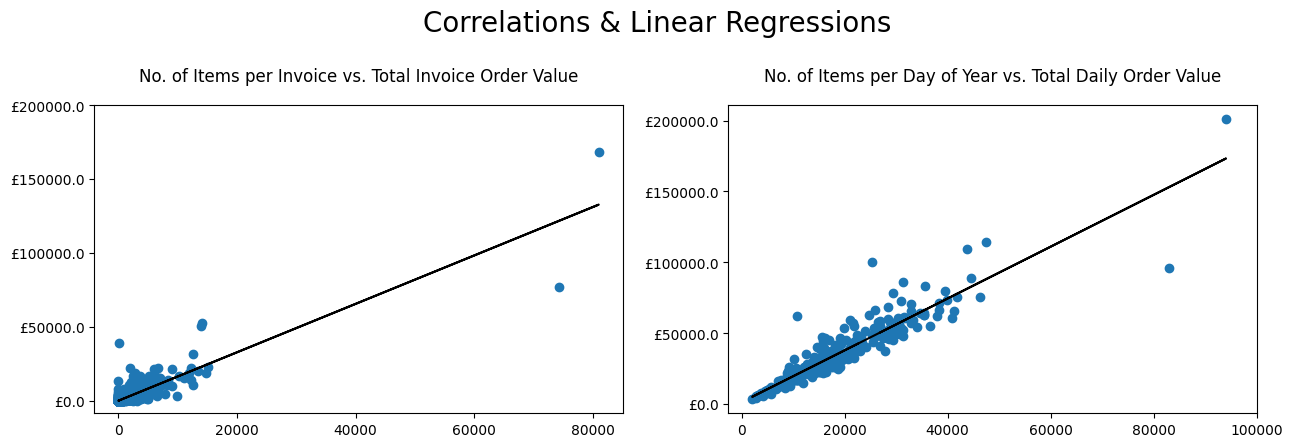

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
fig.suptitle("Correlations & Linear Regressions", y=1.12, fontsize=20)

Linreg1 = LinearRegression().fit(final_df_by_invoice[["NoofItems"]], final_df_by_invoice[["OrderTotal"]])
ax[0].scatter(x=final_df_by_invoice["NoofItems"], y=final_df_by_invoice["OrderTotal"])
ax[0].plot(final_df_by_invoice["NoofItems"], Linreg1.predict(final_df_by_invoice[["NoofItems"]]), color="black")
ax[0].set_title("No. of Items per Invoice vs. Total Invoice Order Value", y=1.05)
ax[0].set_xticks(ax[0].get_xticks()[1::2])
ax[0].set_yticks(ax[0].get_yticks()[1::2])
ax[0].set_yticklabels(f"{chr(163) + str(t)}" for t in ax[0].get_yticks())

df_for_linreg2 = final_df_by_invoice.groupby(["Year", "Month", "Day"])[["NoofItems", "OrderTotal"]].sum().reset_index()

Linreg2 = LinearRegression().fit(df_for_linreg2[["NoofItems"]], df_for_linreg2[["OrderTotal"]])
ax[1].scatter(x=df_for_linreg2["NoofItems"], y=df_for_linreg2["OrderTotal"])
ax[1].plot(df_for_linreg2["NoofItems"], Linreg2.predict(df_for_linreg2[["NoofItems"]]), color="black")
ax[1].set_title("No. of Items per Day of Year vs. Total Daily Order Value", y=1.05)
ax[1].set_xticks(ax[1].get_xticks()[1:7])
ax[1].set_yticks(ax[1].get_yticks()[1::2])
ax[1].set_yticklabels(f"{chr(163) + str(t)}" for t in ax[1].get_yticks())

print(f""" Correlation per Invoice No. \n {final_df_by_invoice[["NoofItems", "OrderTotal"]].corr().round(4)} \n 
Correlation per Day \n {df_for_linreg2[["NoofItems", "OrderTotal"]].corr().round(4)}""")

;

###### Next, I created histograms to show the distribution of the number of items ordered and the order values. Both of them are in two versions - with and without outliers

''

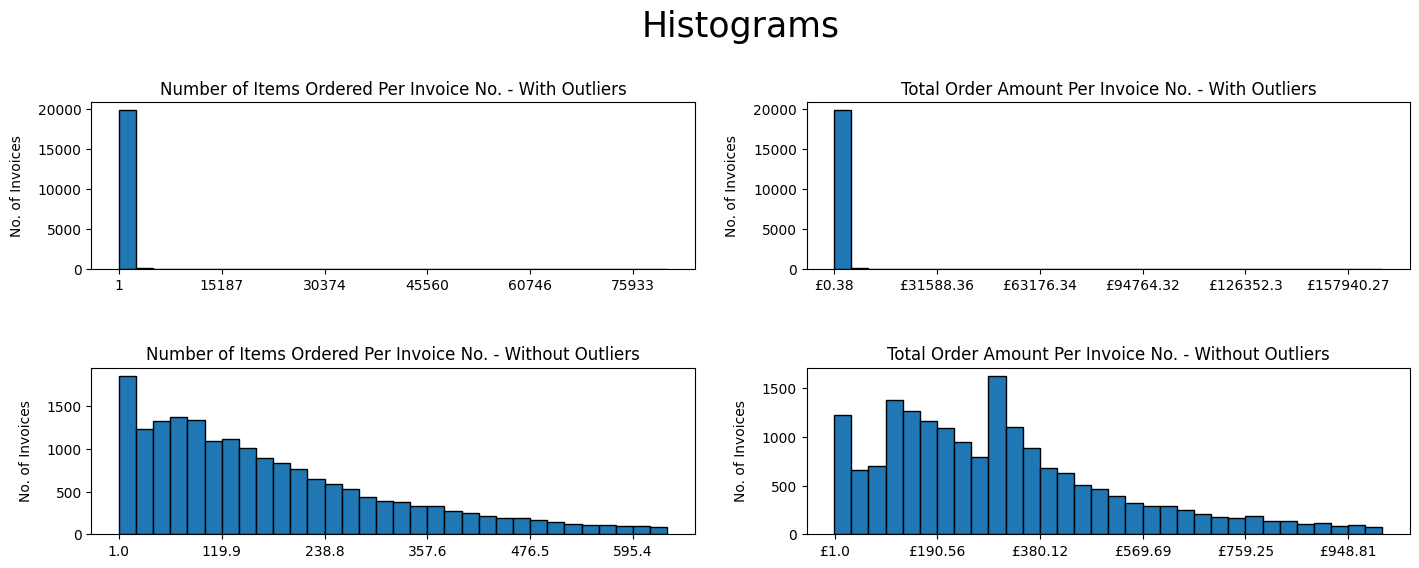

In [21]:
fig, ax = plt.subplots(2,2, figsize=(15,6))
fig.tight_layout(pad=5)
fig.suptitle("Histograms", fontsize=25, y=1.03)

ax[0,0].hist(final_df_by_invoice["NoofItems"], bins = 32, edgecolor = "black")
ax[0,0].set_xticks(np.histogram(final_df_by_invoice["NoofItems"], bins=32)[1][::6])
ax[0,0].set_title("Number of Items Ordered Per Invoice No. - With Outliers")
ax[0,0].set_ylabel("No. of Invoices", labelpad=10)

ax[1,0].hist(final_df_by_invoice["NoofItems"], range=(1, 635), bins=32, edgecolor = "black")
ax[1,0].set_xticks(np.histogram(final_df_by_invoice[(final_df_by_invoice["NoofItems"] >= 1) & 
                            (final_df_by_invoice["NoofItems"] <= 635)]["NoofItems"], bins=32)[1][::6])
ax[1,0].set_title("Number of Items Ordered Per Invoice No. - Without Outliers")
ax[1,0].set_ylabel("No. of Invoices", labelpad=10)

ax[0,1].hist(final_df_by_invoice["OrderTotal"], bins = 32, edgecolor = "black")
ax[0,1].set_xticks(np.histogram(final_df_by_invoice["OrderTotal"], bins=32)[1][::6])
ax[0,1].set_xticklabels(f"{chr(163) + str(x.round(2))}" for x in ax[0,1].get_xticks())
ax[0,1].set_title("Total Order Amount Per Invoice No. - With Outliers")
ax[0,1].set_ylabel("No. of Invoices", labelpad=10)

ax[1,1].hist(final_df_by_invoice["OrderTotal"], range=(0.38, 1012.05), bins=32, edgecolor = "black")
ax[1,1].set_xticks(np.histogram(final_df_by_invoice[(final_df_by_invoice["NoofItems"] >= 0.38) & 
                            (final_df_by_invoice["NoofItems"] <= 1012.05)]["NoofItems"], bins=32)[1][::6])
ax[1,1].set_xticklabels(f"{chr(163) + str(x.round(2))}" for x in ax[1,1].get_xticks())
ax[1,1].set_title("Total Order Amount Per Invoice No. - Without Outliers")
ax[1,1].set_ylabel("No. of Invoices", labelpad=10)
;

###### Then, I wanted to create bar graphs regarding the parameters of items ordered and order values but present them grouped by years, quarters, and months

###### To do that, I again had to create versions of the main dataframe but separately grouped by years, quarters, and months

In [22]:
Invoice_df_by_year = final_df_by_invoice.groupby("Year").agg(
    Noofinvoices = pd.NamedAgg("InvoiceNo", "count"),
    Totalnoofitems = pd.NamedAgg("NoofItems", "sum"),
    Avgnoofitems = pd.NamedAgg("NoofItems", "mean"),
    Medianofitems = pd.NamedAgg("NoofItems", "median"),
    Totalordervalue = pd.NamedAgg("OrderTotal", "sum"),
    Avgordervalue = pd.NamedAgg("OrderTotal", "mean"),
    Medianordervalue = pd.NamedAgg("OrderTotal", "median")
).round(2)

In [23]:
Invoice_df_by_qtr = final_df_by_invoice.groupby(["Year", final_df_by_invoice["InvoiceDate"].dt.quarter]).agg(
    Noofinvoices = pd.NamedAgg("InvoiceNo", "count"),
    Totalnoofitems = pd.NamedAgg("NoofItems", "sum"),
    Avgnoofitems = pd.NamedAgg("NoofItems", "mean"),
    Medianofitems = pd.NamedAgg("NoofItems", "median"),
    Totalordervalue = pd.NamedAgg("OrderTotal", "sum"),
    Avgordervalue = pd.NamedAgg("OrderTotal", "mean"),
    Medianordervalue = pd.NamedAgg("OrderTotal", "median")
).round(2)

In [24]:
Invoice_df_by_month = final_df_by_invoice.groupby(["Year", "Month", final_df_by_invoice["InvoiceDate"].dt.month]).agg(
    Noofinvoices = pd.NamedAgg("InvoiceNo", "count"),
    Totalnoofitems = pd.NamedAgg("NoofItems", "sum"),
    Avgnoofitems = pd.NamedAgg("NoofItems", "mean"),
    Medianofitems = pd.NamedAgg("NoofItems", "median"),
    Totalordervalue = pd.NamedAgg("OrderTotal", "sum"),
    Avgordervalue = pd.NamedAgg("OrderTotal", "mean"),
    Medianordervalue = pd.NamedAgg("OrderTotal", "median")
).round(2).sort_index(level=[0,2])

###### Once I had the dataframes, I created the graphs

''

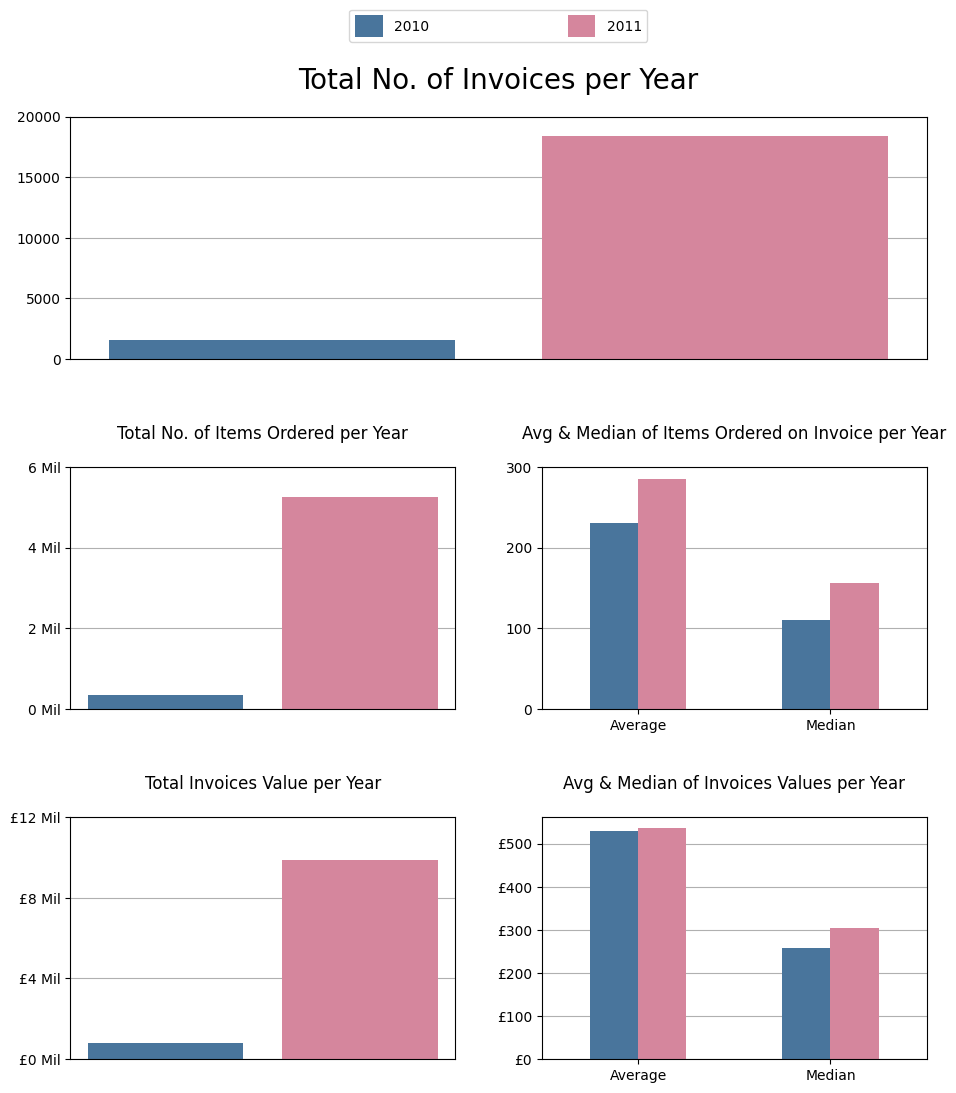

In [25]:
fig = plt.figure(figsize=(10,11))

ax1 = plt.subplot2grid((3,2), (0,0), colspan=2)
ax2 = plt.subplot2grid((3,2), (1,0), colspan=1)
ax3 = plt.subplot2grid((3,2), (1,1), colspan=1)
ax4 = plt.subplot2grid((3,2), (2,0), colspan=1)
ax5 = plt.subplot2grid((3,2), (2,1), colspan=1)

for ax, c in list(zip([ax1,ax2,ax4], Invoice_df_by_year.columns[[0,1,4]])):
    ax.bar(Invoice_df_by_year.index, Invoice_df_by_year[c], color = ["xkcd:dull blue", "xkcd:dull pink"])

#ax3
Invoice_df_by_year[["Avgnoofitems", "Medianofitems"]].transpose().plot.bar(rot=0, ax=ax3, legend=False,
                                                                           color = ["xkcd:dull blue", "xkcd:dull pink"])
ax3.set_xticklabels(["Average", "Median"])

#ax5
Invoice_df_by_year[["Avgordervalue", "Medianordervalue"]].transpose().plot.bar(rot=0, ax=ax5, legend=False,
                                                                               color = ["xkcd:dull blue", "xkcd:dull pink"])
ax5.set_xticklabels(["Average", "Median"])
ax5.set_yticks(ax5.get_yticks())
ax5.set_yticklabels(f"{chr(163) + str(int(l))}" for l in ax5.get_yticks())

for ax in [ax1,ax2,ax4]:
    ax.set_xticks([])

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_yticks(ax.get_yticks()[::2])

ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels(f"{str(int(l/1000000))} Mil" for l in ax2.get_yticks())

ax4.set_yticks(ax4.get_yticks())
ax4.set_yticklabels(f"{chr(163) + str(int(l/1000000))} Mil" for l in ax4.get_yticks())

ax1.set_title("Total No. of Invoices per Year", y=1.08, fontsize= 20)
ax2.set_title("Total No. of Items Ordered per Year", y=1.08)
ax3.set_title("Avg & Median of Items Ordered on Invoice per Year", y=1.08)
ax4.set_title("Total Invoices Value per Year", y=1.08)
ax5.set_title("Avg & Median of Invoices Values per Year", y=1.08)


for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.grid(visible=True, which="major", axis="y")
    ax.set_axisbelow(True)


fig.tight_layout(pad=3)
fig.legend(handles= plt.bar([2010,2011],[0,0],color=["xkcd:dull blue", "xkcd:dull pink"]), labels=[2010,2011],
           bbox_to_anchor=[0.53,1.02], loc = "upper center", ncols= 2, columnspacing = 10, handleheight=2)
;

''

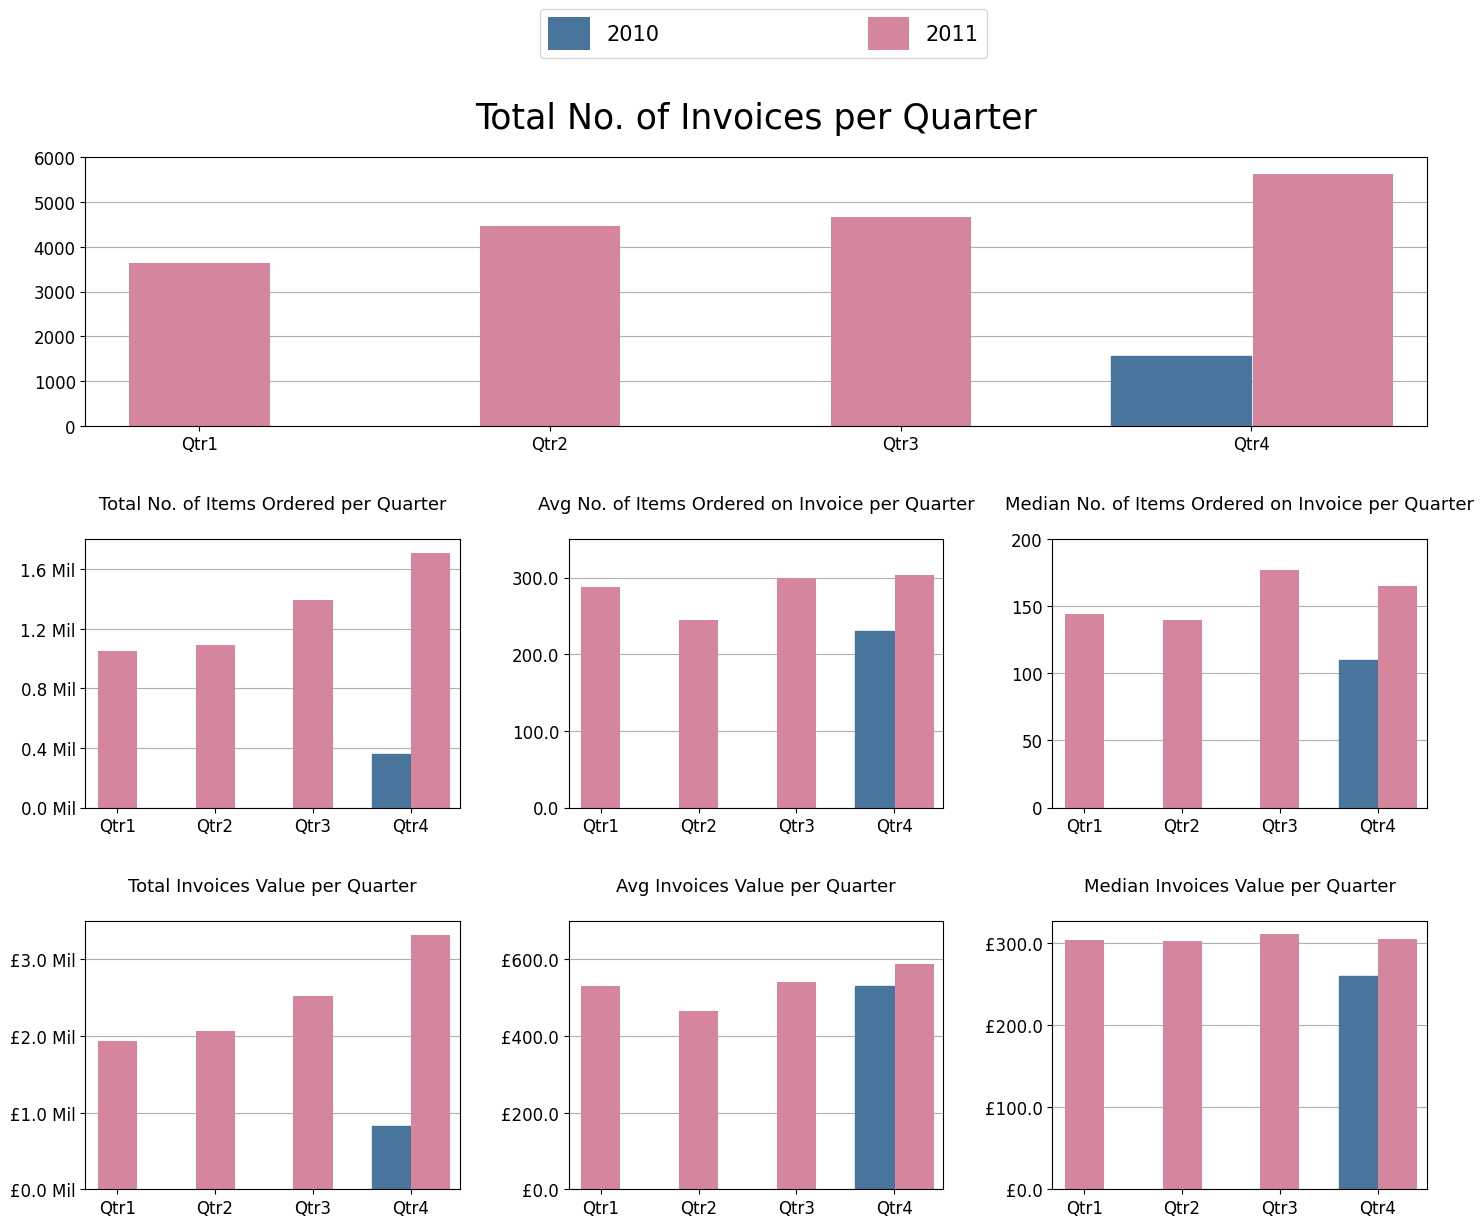

In [26]:
fig = plt.figure(figsize=(15,12))

def Qtrfix(ax):
    ax.patches[0].set_x(8.2)
    ax.patches[0].set_color("xkcd:dull blue")
    ax.patches[4].set_x(9.01)
    ax.set_xticks([3,5,7,9])
    ax.set_xticklabels(["Qtr1", "Qtr2", "Qtr3", "Qtr4"], fontsize=12)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticks(), fontsize=12)
    ax.set_xlim(2.35,10)

ax1 = plt.subplot2grid((3,3), (0,0), colspan=3)
ax2 = plt.subplot2grid((3,3), (1,0), colspan=1)
ax3 = plt.subplot2grid((3,3), (1,1), colspan=1)
ax4 = plt.subplot2grid((3,3), (1,2), colspan=1)
ax5 = plt.subplot2grid((3,3), (2,0), colspan=1)
ax6 = plt.subplot2grid((3,3), (2,1), colspan=1)
ax7 = plt.subplot2grid((3,3), (2,2), colspan=1)


for ax,c in list(zip([ax1,ax2,ax3,ax4,ax5,ax6,ax7], Invoice_df_by_qtr.columns)):
    ax.bar([1,3,5,7,9], Invoice_df_by_qtr[c], color="xkcd:dull pink")
    ax.grid(visible=True, which="major", axis="y")
    ax.set_axisbelow(True)
    Qtrfix(ax)

for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    ax.set_yticks(ax.get_yticks()[::2])

for ax in [ax6,ax7]:
    ax.set_yticklabels(f"{chr(163) + str(l)}" for l in ax.get_yticks())


ax1.set_yticklabels(f"{int(l)}" for l in ax1.get_yticks())

ax2.set_yticklabels(f"{str(l/1000000)} Mil" for l in ax2.get_yticks())

ax4.set_yticklabels(f"{int(l)}" for l in ax4.get_yticks())

ax5.set_yticklabels(f"{chr(163) + str(l/1000000)} Mil" for l in ax5.get_yticks())


ax1.set_title("Total No. of Invoices per Quarter", y=1.08, fontsize=25)
ax2.set_title("Total No. of Items Ordered per Quarter", y=1.08, fontsize=13)
ax3.set_title("Avg No. of Items Ordered on Invoice per Quarter", y=1.08, fontsize=13)
ax4.set_title("Median No. of Items Ordered on Invoice per Quarter", y=1.08, fontsize=13)
ax5.set_title("Total Invoices Value per Quarter", y=1.08, fontsize=13)
ax6.set_title("Avg Invoices Value per Quarter", y=1.08, fontsize=13)
ax7.set_title("Median Invoices Value per Quarter", y=1.08, fontsize=13)

fig.tight_layout(pad=3)
fig.legend(handles= plt.bar([2010,2011],[0,0],color=["xkcd:dull blue", "xkcd:dull pink"]), labels=[2010,2011],
           bbox_to_anchor=[0.53,1.05], loc = "upper center", ncols= 2, columnspacing = 10, handleheight=2,
           fontsize=15)
;

''

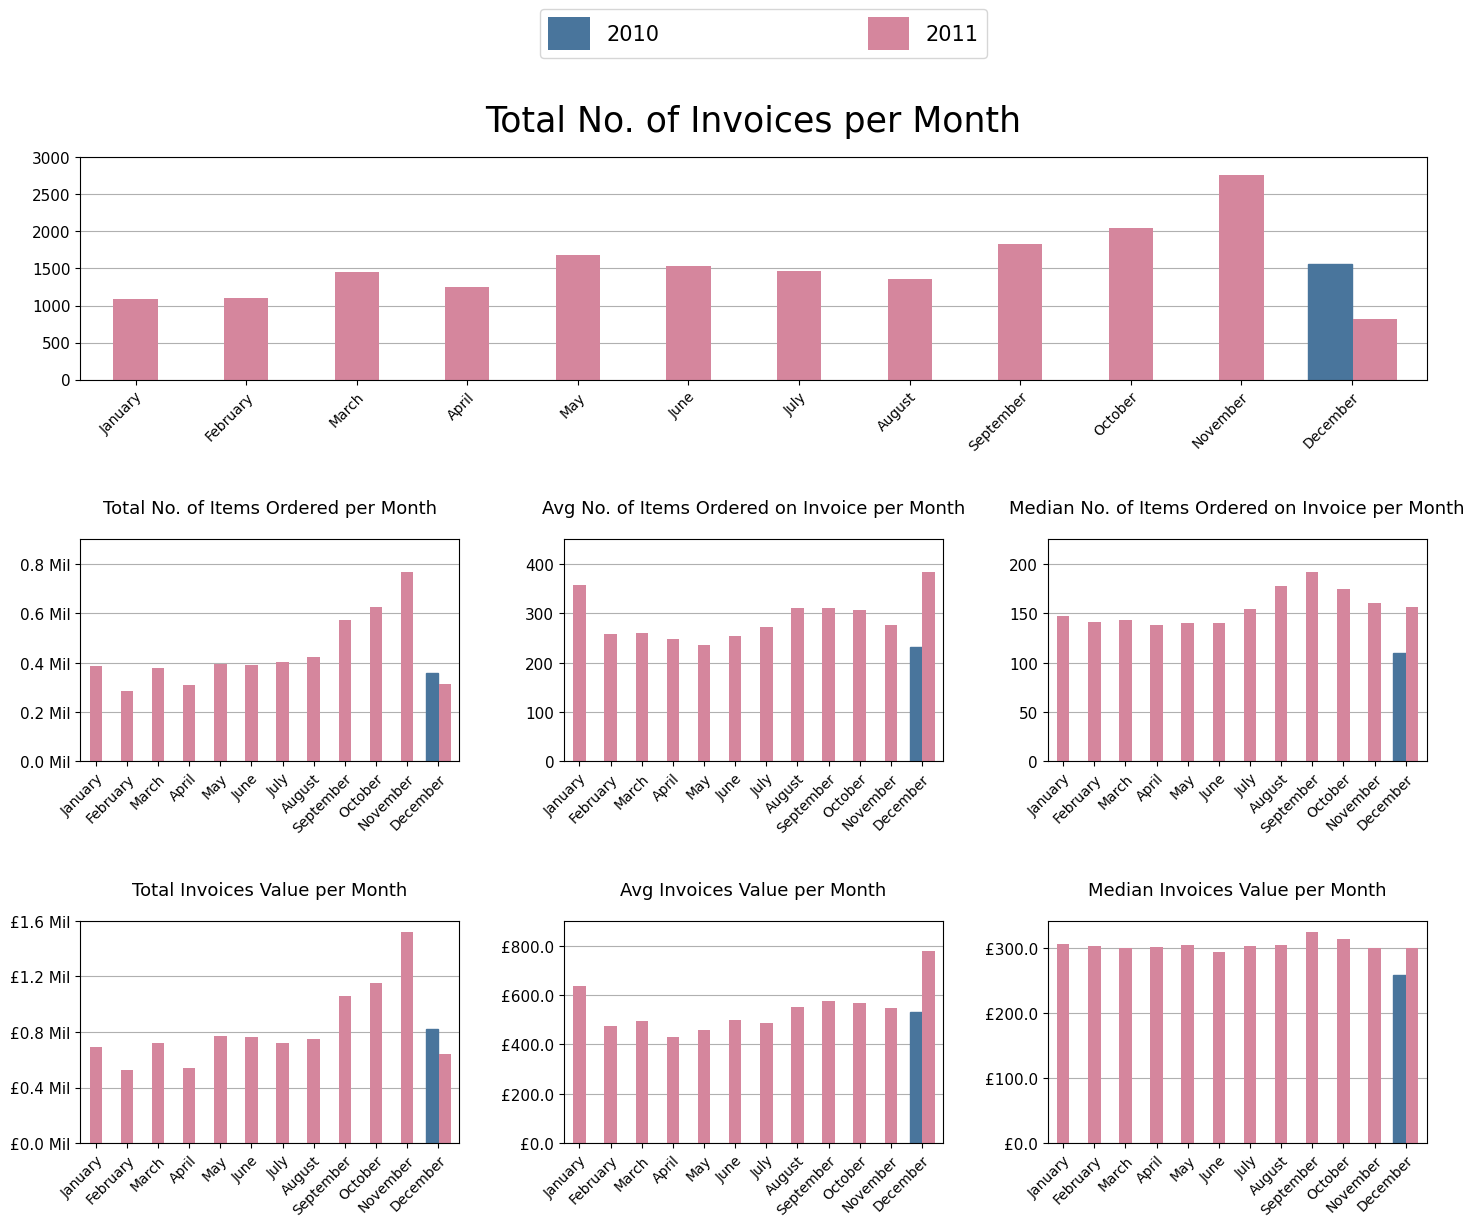

In [27]:
fig = plt.figure(figsize=(15,12))

def Qtrfix(ax):
    ax.patches[0].set_x(24.2)
    ax.patches[0].set_color("xkcd:dull blue")
    ax.patches[12].set_x(25.02)
    ax.set_xticks(np.arange(3,27,2))
    ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July", "August", "September", 
                        "October", "November", "December"], rotation=45, ha="right", rotation_mode="anchor",
                        fontsize=10)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticks(), fontsize=11)
    ax.set_xlim(2,26.35)

ax1 = plt.subplot2grid((3,3), (0,0), colspan=3)
ax2 = plt.subplot2grid((3,3), (1,0), colspan=1)
ax3 = plt.subplot2grid((3,3), (1,1), colspan=1)
ax4 = plt.subplot2grid((3,3), (1,2), colspan=1)
ax5 = plt.subplot2grid((3,3), (2,0), colspan=1)
ax6 = plt.subplot2grid((3,3), (2,1), colspan=1)
ax7 = plt.subplot2grid((3,3), (2,2), colspan=1)


for ax,c in list(zip([ax1,ax2,ax3,ax4,ax5,ax6,ax7], Invoice_df_by_month.columns)):
    ax.bar(np.arange(1,27,2), Invoice_df_by_month[c], color="xkcd:dull pink")
    ax.grid(visible=True, which="major", axis="y")
    ax.set_axisbelow(True)
    Qtrfix(ax)

for ax in [ax3,ax4,ax6,ax7]:
    ax.set_yticks(ax.get_yticks()[::2])

for ax in [ax3,ax4]:
    ax.set_yticklabels(f"{int(l)}" for l in ax.get_yticks())

for ax in [ax6,ax7]:
    ax.set_yticklabels(f"{chr(163) + str(l)}" for l in ax.get_yticks())


ax1.set_yticklabels(f"{int(l)}" for l in ax1.get_yticks())

ax2.set_yticks(ax2.get_yticks()[::2])
ax2.set_yticklabels(f"{str(l/1000000)} Mil" for l in ax2.get_yticks())

ax5.set_yticks(ax5.get_yticks()[::2])
ax5.set_yticklabels(f"{chr(163) + str(l/1000000)} Mil" for l in ax5.get_yticks())


ax1.set_title("Total No. of Invoices per Month", y=1.08, fontsize=25)
ax2.set_title("Total No. of Items Ordered per Month", y=1.08, fontsize=13)
ax3.set_title("Avg No. of Items Ordered on Invoice per Month", y=1.08, fontsize=13)
ax4.set_title("Median No. of Items Ordered on Invoice per Month", y=1.08, fontsize=13)
ax5.set_title("Total Invoices Value per Month", y=1.08, fontsize=13)
ax6.set_title("Avg Invoices Value per Month", y=1.08, fontsize=13)
ax7.set_title("Median Invoices Value per Month", y=1.08, fontsize=13)

fig.tight_layout(pad=3)
fig.legend(handles= plt.bar([2010,2011],[0,0],color=["xkcd:dull blue", "xkcd:dull pink"]), labels=[2010,2011],
           bbox_to_anchor=[0.53,1.05], loc = "upper center", ncols= 2, columnspacing = 10, handleheight=2,
           fontsize=15)
;

###### Here, curious about November's results, I'm checking what items sold most often and if there is any general trend

In [28]:
final_df[final_df["Month"] == "November"]["Description"].value_counts().head(10)

Description
Rabbit Night Light                    516
Paper Chain Kit 50'S Christmas        406
Hot Water Bottle Keep Calm            303
Paper Chain Kit Vintage Christmas     282
Jumbo Bag 50'S Christmas              274
White Hanging Heart T-Light Holder    269
Popcorn Holder                        256
Wooden Star Christmas Scandinavian    255
Jumbo Bag Red Retrospot               250
Jumbo Bag Paisley Park                246
Name: count, dtype: int64

###### With the graphs for years, quarters and months finished, I then wanted to create bar graphs regarding the same values but grouped by countries

''

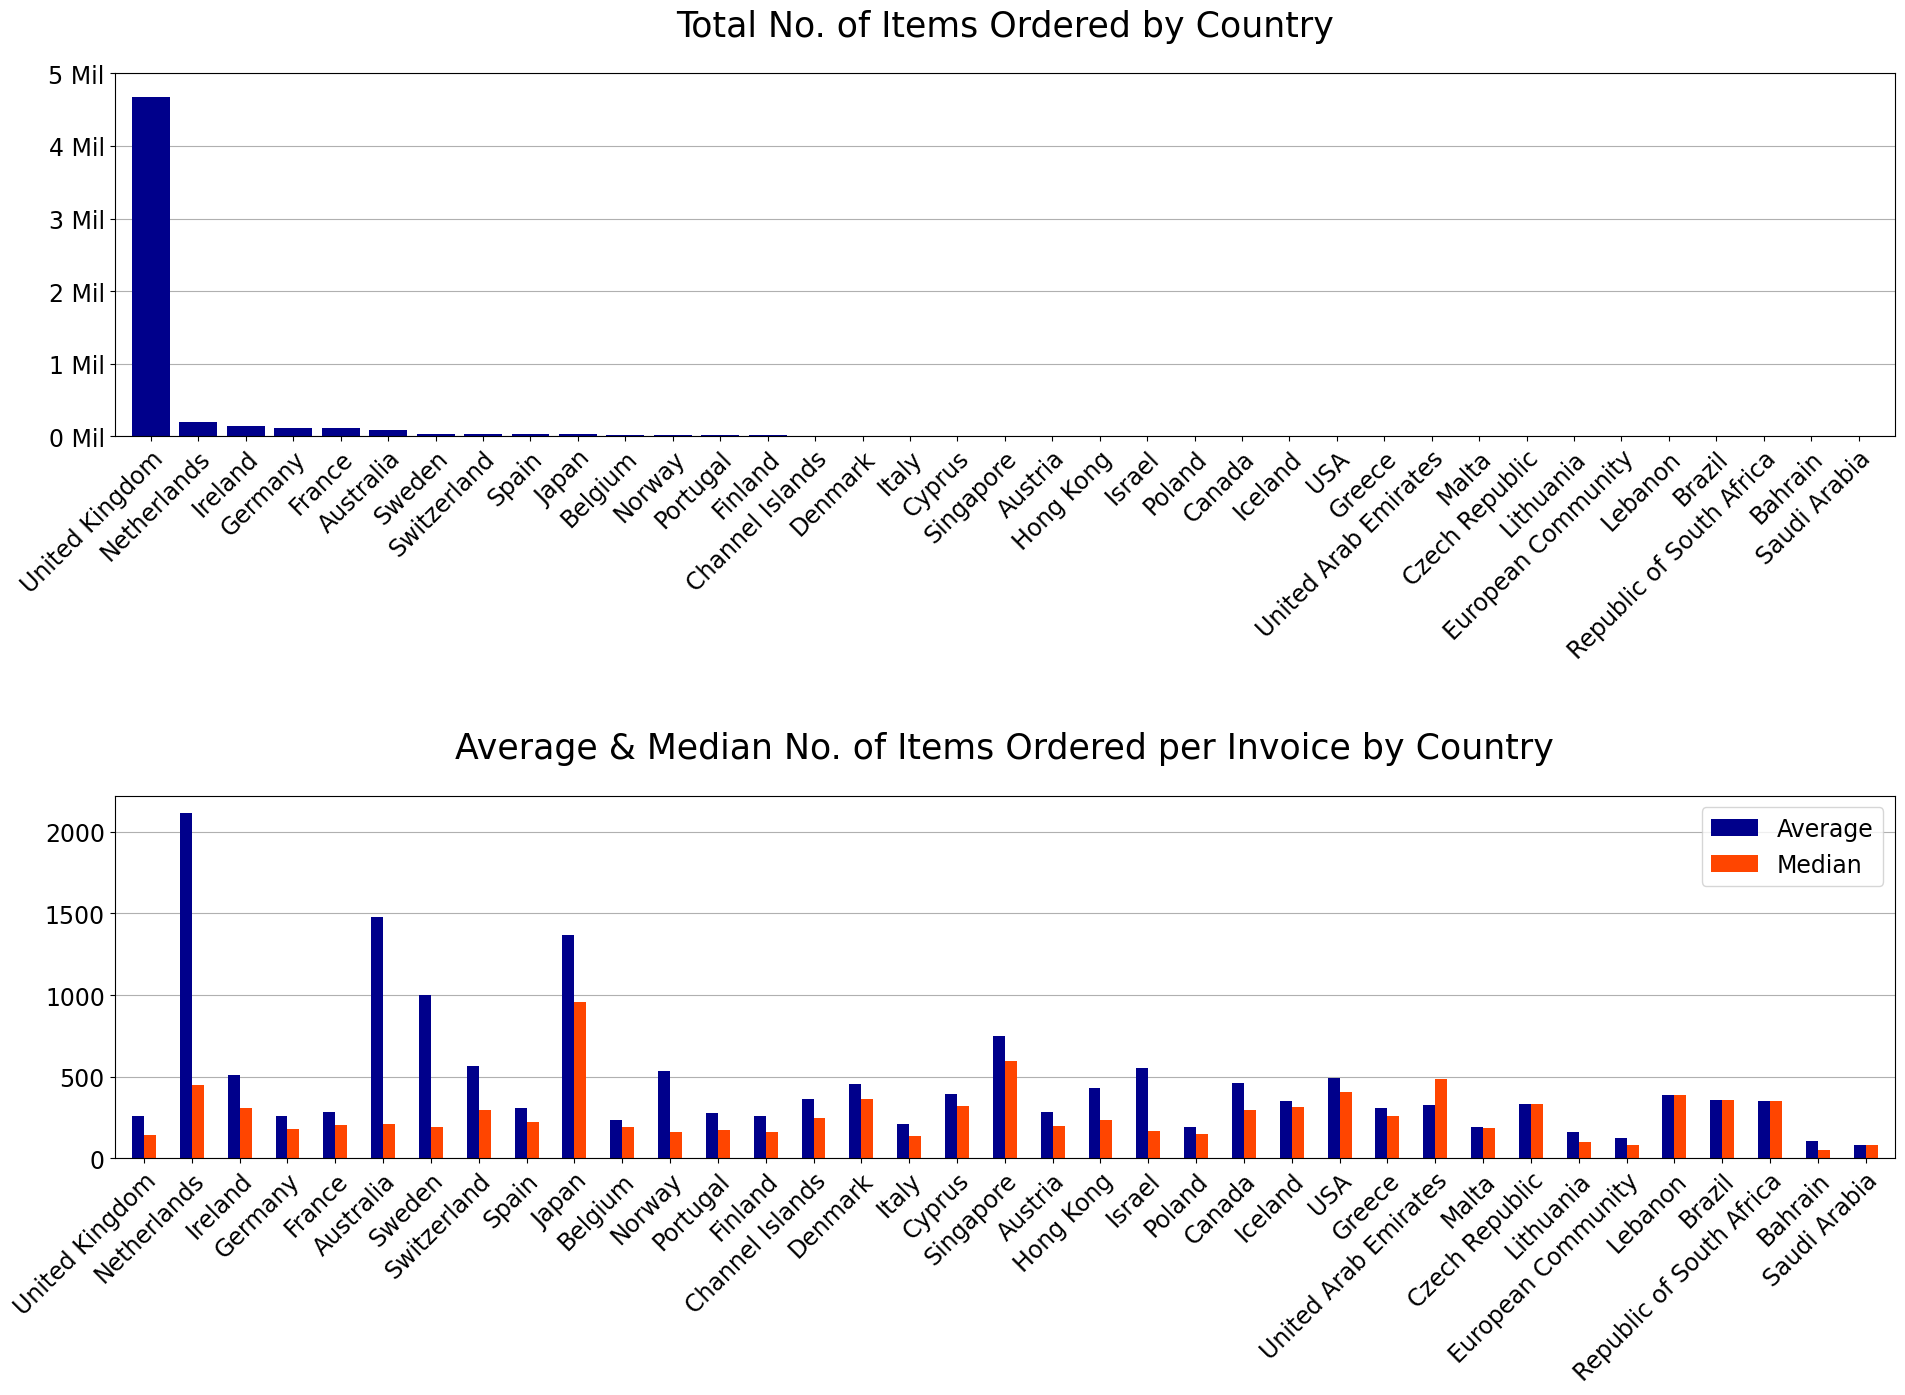

In [29]:
fig, ax = plt.subplots(2,1, figsize = (20,15))

ax[0].bar(Invoice_df_by_country_items.index, Invoice_df_by_country_items["TotalItems"], color="darkblue")
ax[0].margins(0.01)
ax[0].set_xticks(Invoice_df_by_country_items.index)
ax[0].set_xticklabels(Invoice_df_by_country_items.index, rotation=45, ha="right", rotation_mode="anchor",fontsize=17)
ax[0].set_yticks(ax[0].get_yticks())
ax[0].set_yticklabels([f"{str(int(l/1000000))} Mil" for l in ax[0].get_yticks()], fontsize=17)

Invoice_df_by_country_items[["AvgNoofItems", "MedianNoofItems"]].plot.bar(ax=ax[1], color=["darkblue", "orangered"])
ax[1].set_xlabel(None)
ax[1].margins(x=0.01)
ax[1].autoscale(tight=False)
ax[1].legend(["Average", "Median"], fontsize=17)
ax[1].set_xticklabels(Invoice_df_by_country_items.index, rotation=45, ha="right", rotation_mode="anchor",fontsize=17)
ax[1].set_yticks(ax[1].get_yticks()[::2])
ax[1].set_yticklabels([f"{str(int(l))}" for l in ax[1].get_yticks()], fontsize=17)

ax[0].set_title("Total No. of Items Ordered by Country", fontsize=25, y=1.08)
ax[1].set_title("Average & Median No. of Items Ordered per Invoice by Country", fontsize=25, y=1.08)

for ax in [ax[0], ax[1]]:
    ax.grid(visible=True, which="major", axis="y")
    ax.set_axisbelow(True)

fig.tight_layout(pad=4)
;

''

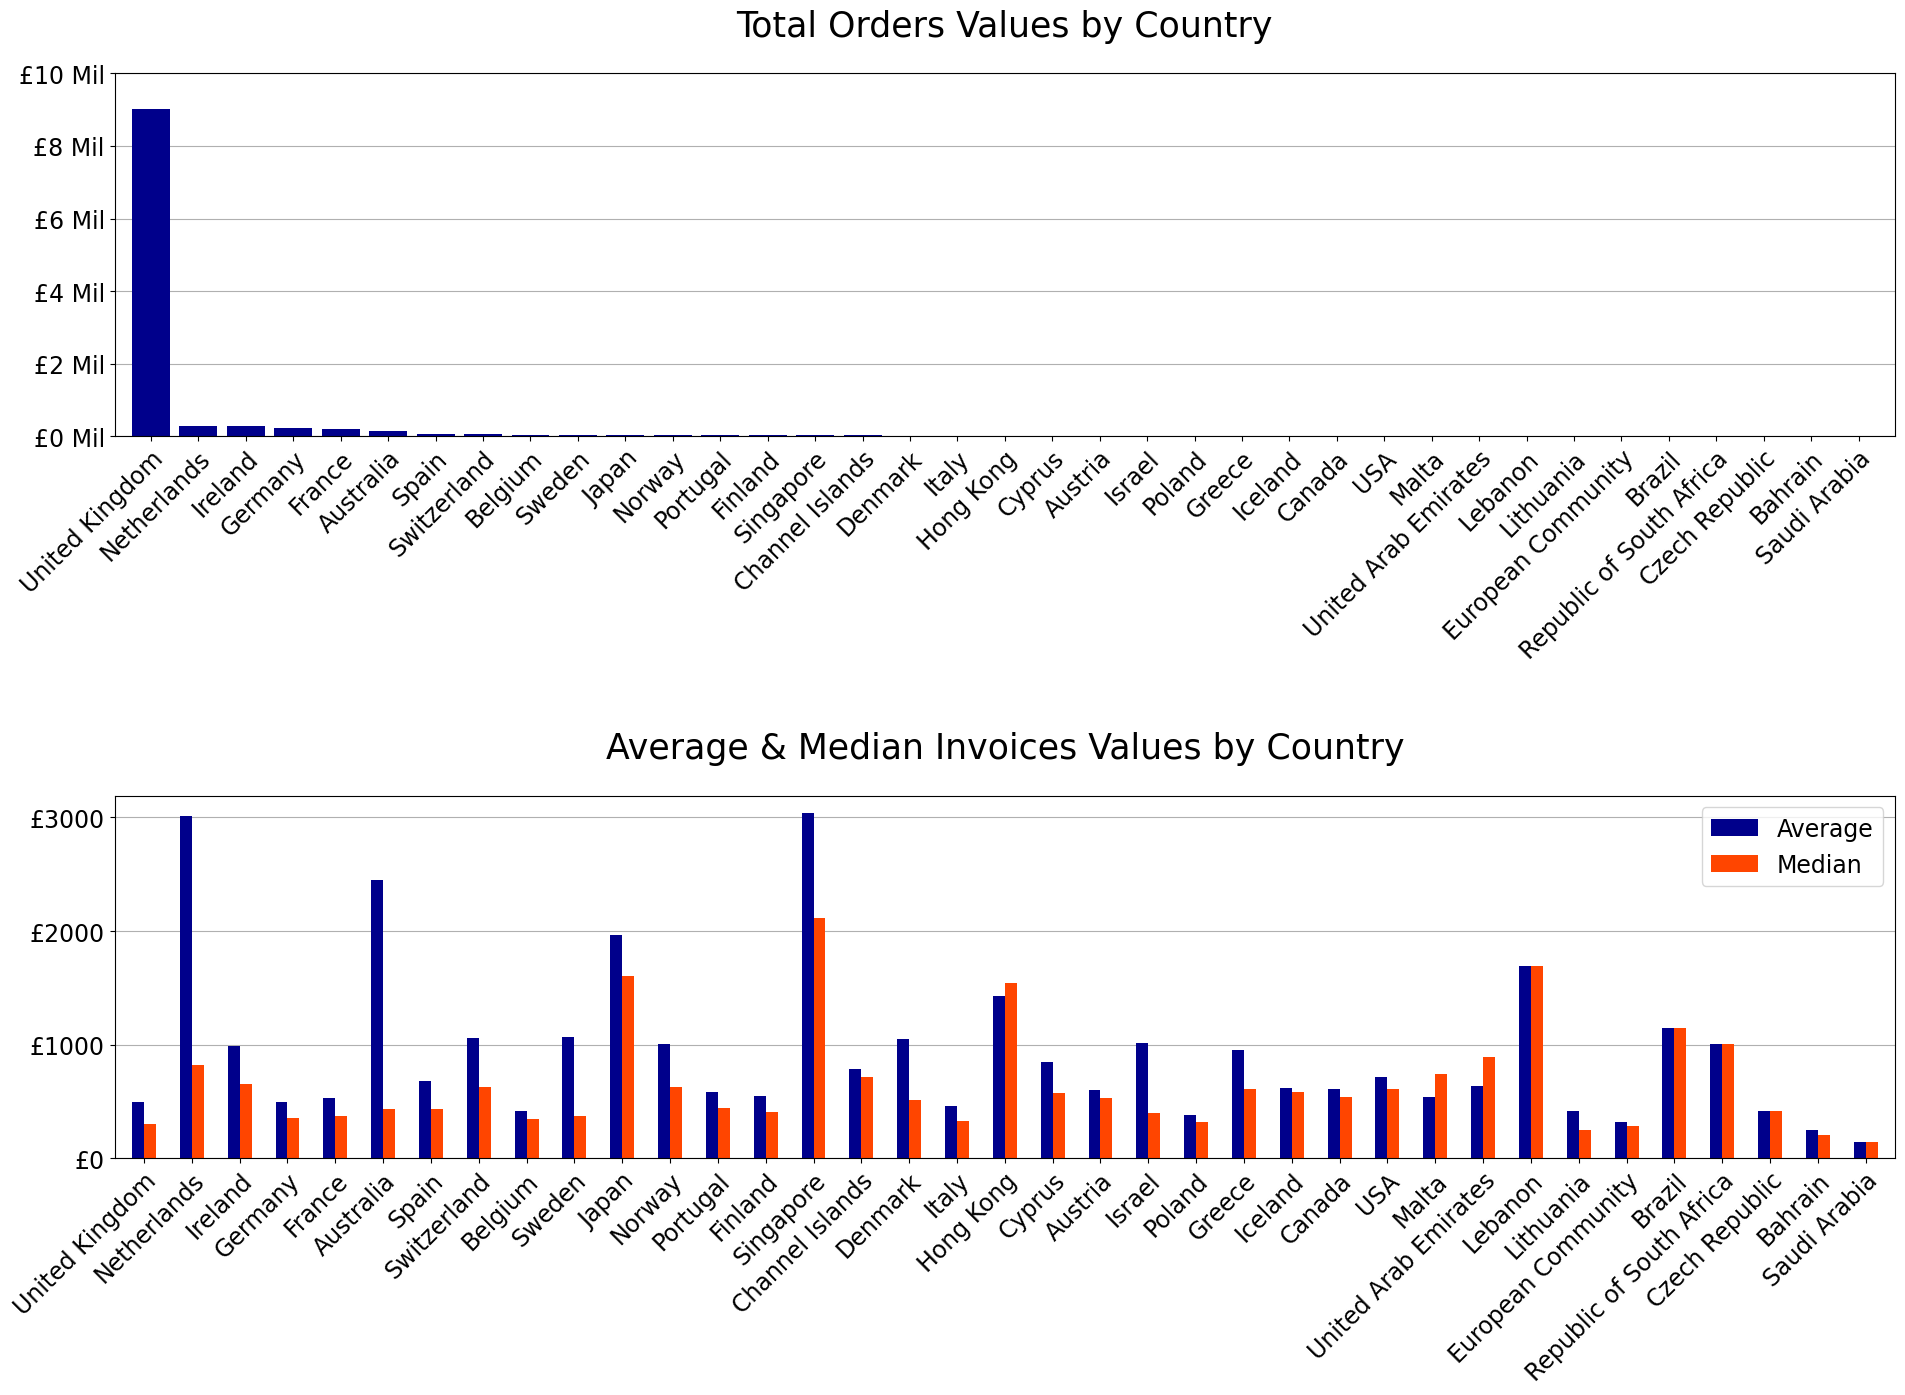

In [30]:
fig, ax = plt.subplots(2,1, figsize = (20,15))

ax[0].bar(Invoice_df_by_country_amount.index, Invoice_df_by_country_amount["TotalAmount"], color="darkblue")
ax[0].margins(0.01)
ax[0].set_xticks(Invoice_df_by_country_amount.index)
ax[0].set_xticklabels(Invoice_df_by_country_amount.index, rotation=45, ha="right", rotation_mode="anchor",fontsize=17)
ax[0].set_yticks(ax[0].get_yticks())
ax[0].set_yticklabels([f"{chr(163) + str(int(l/1000000))} Mil" for l in ax[0].get_yticks()], fontsize=17)

Invoice_df_by_country_amount[["AvgAmount", "MedianAmount"]].plot.bar(ax=ax[1], color=["darkblue", "orangered"])
ax[1].set_xlabel(None)
ax[1].margins(x=0.01)
ax[1].autoscale(tight=False)
ax[1].legend(["Average", "Median"], fontsize=17)
ax[1].set_xticklabels(Invoice_df_by_country_amount.index, rotation=45, ha="right", rotation_mode="anchor",fontsize=17)
ax[1].set_yticks(ax[1].get_yticks()[::2])
ax[1].set_yticklabels([f"{chr(163) + str(int(l))}" for l in ax[1].get_yticks()], fontsize=17)

ax[0].set_title("Total Orders Values by Country", fontsize=25, y=1.08)
ax[1].set_title("Average & Median Invoices Values by Country", fontsize=25, y=1.08)

for ax in [ax[0], ax[1]]:
    ax.grid(visible=True, which="major", axis="y")
    ax.set_axisbelow(True)

fig.tight_layout(pad=4)
;

##### Bonus - QQ plots & Confidence Intervals for Top 5 countries with the highest number of items ordered. 

##### In this part, I'm approaching this data as if it was a sample of a population and the actual population was 3 times bigger than what we have here. 

###### Here, I've created functions for creating samples of the data in our current dataframe. The sample sizes are 10% of the number of records for each country in this dataset. Even though with the assumption made before we could've taken bigger samples, I decided to stick with the 10%.

###### Additionally, I'm already preparing all the data necessary to create QQ plots. I'm ranking the sorted data, calculating the percentile probability of achieving smaller values than the value of our rank, the theoretical z scores based on the percentiles and the z scores of our data

In [31]:
def Sample_QQ_Items(country):
    """
    The country variable should be added in quotes, for example "United Kingdom" 
    """
    sample = final_df_by_invoice[final_df_by_invoice["Country"] == country][["NoofItems"]].sample(
        int(np.round(final_df_by_invoice[final_df_by_invoice["Country"] == country]["NoofItems"].size*0.10,round(0))),
        replace=False)
    sample.sort_values("NoofItems", inplace=True)
    sample["Rank"] = sample["NoofItems"].rank()
    sample["Percentile"] = (sample["Rank"]-0.5)/sample["Rank"].count()
    sample["Normal_Theoretical_Quantiles"] = norm.ppf(sample["Percentile"])
    sample["Data_Quantiles"] = (sample["NoofItems"]-sample["NoofItems"].mean())/sample["NoofItems"].std(ddof=1)
    return sample

def Sample_QQ_Values(country):
    """
    The country variable should be added in quotes, for example "United Kingdom" 
    """
    sample = final_df_by_invoice[final_df_by_invoice["Country"] == country][["OrderTotal"]].sample(
        int(np.round(final_df_by_invoice[final_df_by_invoice["Country"] == country]["OrderTotal"].size*0.10,round(0))),
        replace=False)
    sample.sort_values("OrderTotal", inplace=True)
    sample["Rank"] = sample["OrderTotal"].rank()
    sample["Percentile"] = (sample["Rank"]-0.5)/sample["Rank"].count()
    sample["Normal_Theoretical_Quantiles"] = norm.ppf(sample["Percentile"])
    sample["Data_Quantiles"] = (sample["OrderTotal"]-sample["OrderTotal"].mean())/sample["OrderTotal"].std(ddof=1)
    return sample

###### Next, I'm just applying the function to each of the top 5 countries to create samples

In [32]:
UK_sample_items = Sample_QQ_Items("United Kingdom")
NE_sample_items = Sample_QQ_Items("Netherlands")
IR_sample_items = Sample_QQ_Items("Ireland")
GER_sample_items = Sample_QQ_Items("Germany")
FR_sample_items = Sample_QQ_Items("France")

UK_sample_value = Sample_QQ_Values("United Kingdom")
NE_sample_value = Sample_QQ_Values("Netherlands")
IR_sample_value = Sample_QQ_Values("Ireland")
GER_sample_value = Sample_QQ_Values("Germany")
FR_sample_value = Sample_QQ_Values("France")

###### Checking the sizes of samples

In [33]:
print(UK_sample_items["NoofItems"].count(),NE_sample_items["NoofItems"].count(),IR_sample_items["NoofItems"].count(),
      GER_sample_items["NoofItems"].count(),FR_sample_items["NoofItems"].count())

1803 10 29 46 39


###### Next, I'm creating another function, that will help us with plotting the QQ plots for each country

In [59]:

def QQplots(Items_sample, Values_sample, country):
   """
   The country variable should be added in quotes, for example "United Kingdom" 
   """
   x_y_i = [np.min([Items_sample["Normal_Theoretical_Quantiles"], Items_sample["Data_Quantiles"]]), 
            np.max([Items_sample["Normal_Theoretical_Quantiles"], Items_sample["Data_Quantiles"]])]
   
   x_y_v = [np.min([Values_sample["Normal_Theoretical_Quantiles"], Values_sample["Data_Quantiles"]]), 
            np.max([Values_sample["Normal_Theoretical_Quantiles"], Values_sample["Data_Quantiles"]])]
    
   fig, ax = plt.subplots(1,2, figsize=(10,5))
   fig.suptitle(country, fontsize=20)

   ax[0].scatter(x=Items_sample["Normal_Theoretical_Quantiles"], y=Items_sample["Data_Quantiles"])
   ax[0].set_xlabel("Norm. Theoretical Quantiles")
   ax[0].set_ylabel("Data Quantiles")
   ax[0].plot(x_y_i, x_y_i, color='r')
   ax[0].set_title("QQ Plot of No. of Items Ordered per Invoice", y=1.08)

   ax[1].scatter(x=Values_sample["Normal_Theoretical_Quantiles"], y=Values_sample["Data_Quantiles"])
   ax[1].set_xlabel("Norm. Theoretical Quantiles")
   ax[1].set_ylabel("Data Quantiles")
   ax[1].plot(x_y_v, x_y_v, color="red")
   ax[1].set_title("QQ Plot of Invoices Values", y=1.08)

   fig.tight_layout(w_pad=10);

###### Then, I'm using that function to create QQ plots for each country

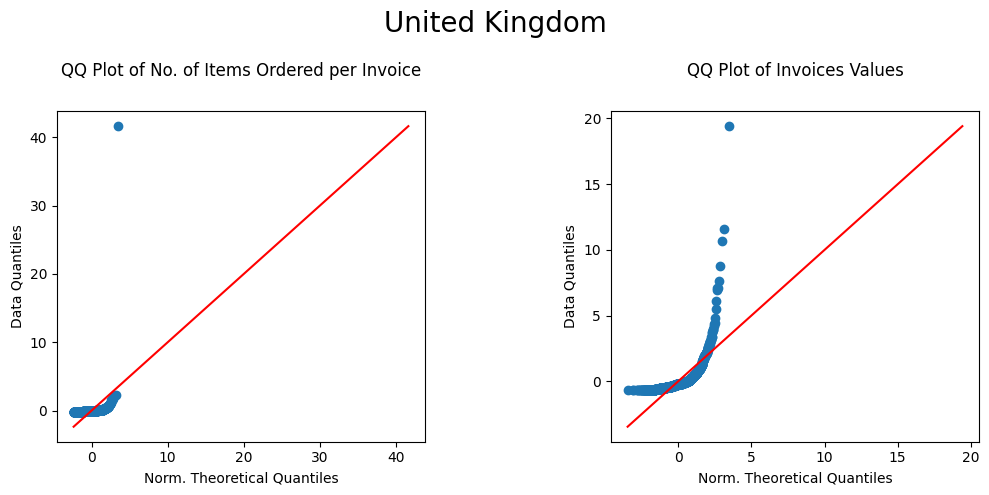

In [60]:
QQplots(UK_sample_items, UK_sample_value, "United Kingdom")

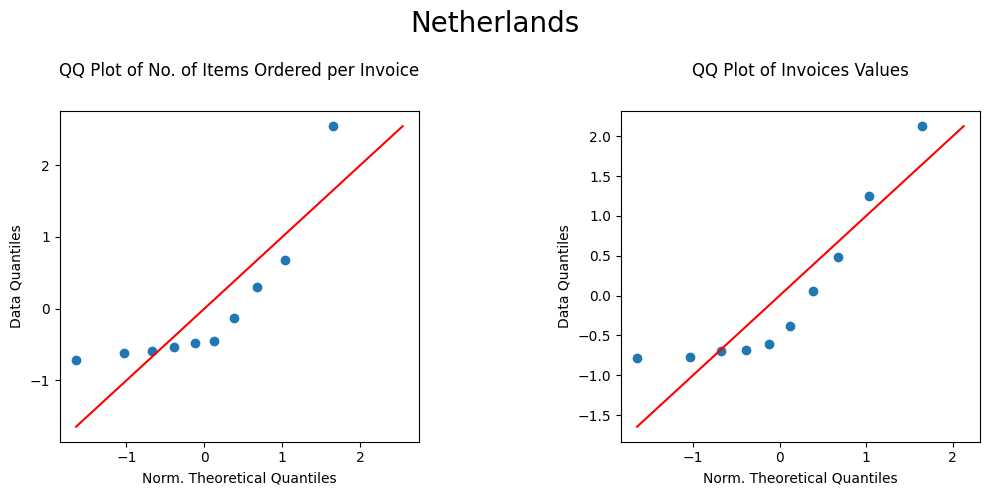

In [61]:
QQplots(NE_sample_items, NE_sample_value, "Netherlands")

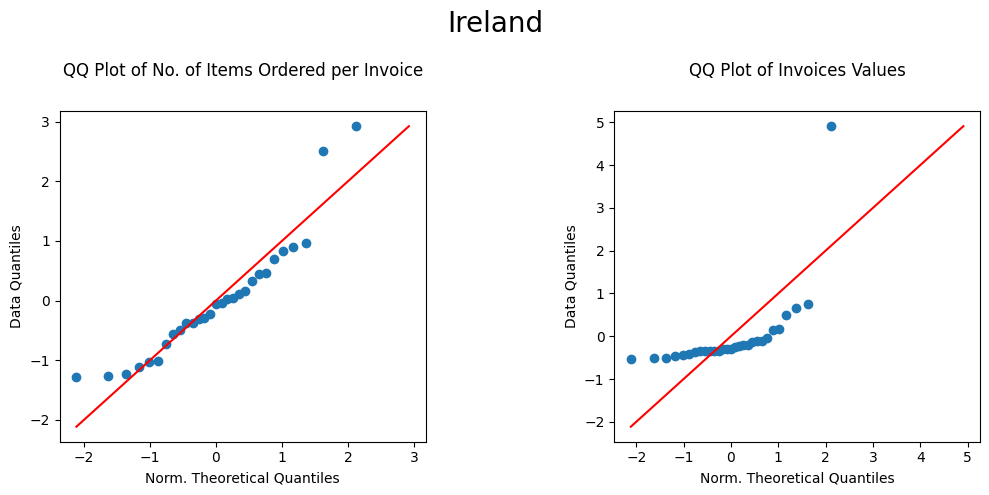

In [62]:
QQplots(IR_sample_items, IR_sample_value, "Ireland")

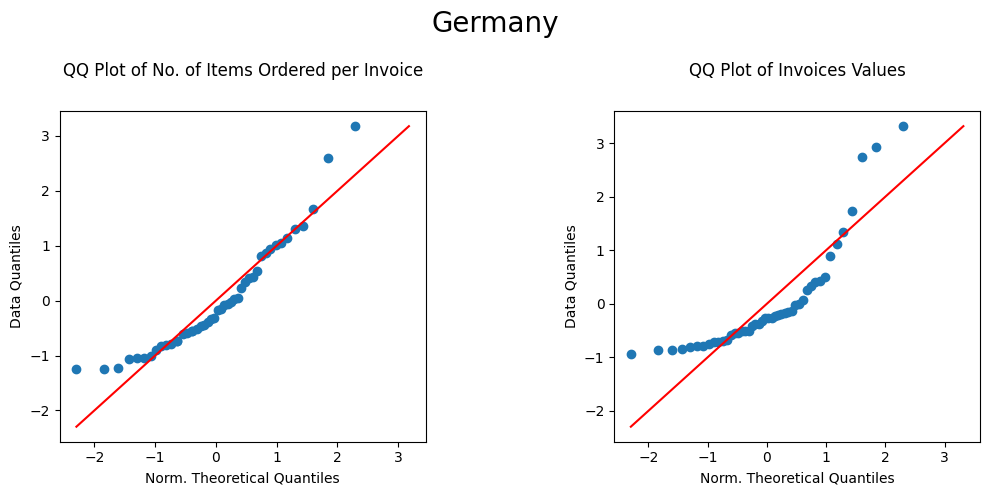

In [63]:
QQplots(GER_sample_items, GER_sample_value, "Germany")

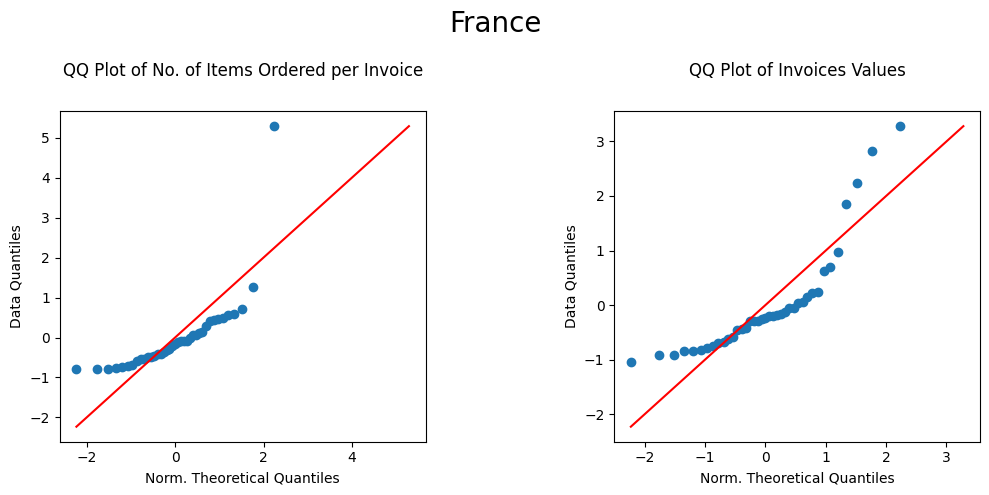

In [64]:
QQplots(FR_sample_items, FR_sample_value, "France")

###### Once done with the sampling and QQ plots, I'm creating a function for the boostrap method to determine the 95% Confidence Interval of mean and median of items ordered and order totals. I've decided to use that non-parametric method because all of the distributions don't look like normal distributions. Samples with a lot of elements, specifically United Kingdom, show extreme difference from a normal distribution, so even if the Central Limit Theorem could apply, due to the skewness, Z-score won't be the most accurate. We also have non-normal samples with less than 30 elements, hence T-score is also not applicable for them. While we could count T-scores for these samples that have more than 30 elements and have a skewed distribution, this would only apply to means, since neither Z-score or T-score are used to calculate medians. In this situation, I decided to use the Bootstrap method.

In [65]:
def Bootstrap(Sample_Items, Sample_Values):
    Bootstrap_Items_list = []
    Bootstrap_Values_list = []
    Means_Items_list = []
    Medians_Items_list = []
    Means_Values_list = []
    Medians_Values_list = []
    Country_Items = Sample_Items["NoofItems"]
    Country_Values = Sample_Values["OrderTotal"]
    for i in range (1000):
        Resampling_Items= resample(Country_Items)
        Resampling_Values = resample(Country_Values)
        Bootstrap_Items_list.append(Resampling_Items)
        Bootstrap_Values_list.append(Resampling_Values)
    for b in Bootstrap_Items_list:
        Means_Items_list.append(b.mean())
        Medians_Items_list.append(b.median())
    for b in Bootstrap_Values_list:
        Means_Values_list.append(b.mean())
        Medians_Values_list.append(b.median())
    Ci_Items_Mean = [np.percentile(Means_Items_list, 2.5).round(2), np.percentile(Means_Items_list, 97.5).round(2)]
    Ci_Items_Median = [np.percentile(Medians_Items_list, 2.5, method="lower").round(2), np.percentile(Medians_Items_list, 97.5, method="lower").round(2)]
    Ci_Values_Mean = [np.percentile(Means_Values_list, 2.5).round(2), np.percentile(Means_Values_list, 97.5).round(2)]
    Ci_Values_Median = [np.percentile(Medians_Values_list, 2.5).round(2), np.percentile(Medians_Values_list, 97.5).round(2)]
    return pd.DataFrame([Ci_Items_Mean, Ci_Items_Median, Ci_Values_Mean, Ci_Values_Median],
                        columns=["Lower", "Upper"], index=["95% Avg Items", "95% Median Items","95% Avg Values", 
                                                           "95% Median Values"])

In [66]:
UK_Ci = Bootstrap(UK_sample_items, UK_sample_value)
NE_Ci = Bootstrap(NE_sample_items, NE_sample_value)
IR_Ci = Bootstrap(IR_sample_items, IR_sample_value)
GER_Ci = Bootstrap(GER_sample_items, GER_sample_value)
FR_Ci = Bootstrap(FR_sample_items, FR_sample_value)

###### Once the bootstrap function was created, I decided to incorporate the results of that function into the QQplot function and show them as a plot with table showing the sample values and the confidence intervals

In [67]:
def QQplots_and_CI(Items_sample, Values_sample, CI, country):
   """
   The country variable should be added in quotes, for example "United Kingdom" 
   """
   x_y_i = [np.min([Items_sample["Normal_Theoretical_Quantiles"], Items_sample["Data_Quantiles"]]), 
            np.max([Items_sample["Normal_Theoretical_Quantiles"], Items_sample["Data_Quantiles"]])]
   
   x_y_v = [np.min([Values_sample["Normal_Theoretical_Quantiles"], Values_sample["Data_Quantiles"]]), 
            np.max([Values_sample["Normal_Theoretical_Quantiles"], Values_sample["Data_Quantiles"]])]
    
   fig, ax = plt.subplots(1,2, figsize=(10,5))
   fig.suptitle(country, fontsize=20, y=0.85)

   ax[0].scatter(x=Items_sample["Normal_Theoretical_Quantiles"], y=Items_sample["Data_Quantiles"])
   ax[0].set_xlabel("Norm. Theoretical Quantiles")
   ax[0].set_ylabel("Data Quantiles")
   ax[0].plot(x_y_i, x_y_i, color='r')
   ax[0].table(cellText=[[Items_sample["NoofItems"].mean().round(2), CI.iloc[0,0], CI.iloc[0,1]],
                        [Items_sample["NoofItems"].median(), CI.iloc[1,0], CI.iloc[1,1]]], bbox=[0,1.05,1,0.3], 
                        colLabels=["Sample Value","Bootstrap 95% Lower", "Bootstrap 95% Upper"], 
                        rowLabels=["Average", "Median"])
   ax[0].set_title("QQ Plot of No. of Items Ordered per Invoice", y=1.4)

   ax[1].scatter(x=Values_sample["Normal_Theoretical_Quantiles"], y=Values_sample["Data_Quantiles"])
   ax[1].set_xlabel("Norm. Theoretical Quantiles")
   ax[1].set_ylabel("Data Quantiles")
   ax[1].plot(x_y_v, x_y_v, color="red")
   ax[1].table(cellText=[[Values_sample["OrderTotal"].mean().round(2), CI.iloc[2,0], CI.iloc[2,1]],
                        [Values_sample["OrderTotal"].median().round(2), CI.iloc[3,0], CI.iloc[3,1]]], bbox=[0,1.05,1,0.3], 
                        colLabels=["Sample Value","Bootstrap 95% Lower", "Bootstrap 95% Upper"], 
                        rowLabels=["Average", "Median"])
   ax[1].set_title("QQ Plot of Invoices Values", y=1.4)

   fig.tight_layout(w_pad=10);

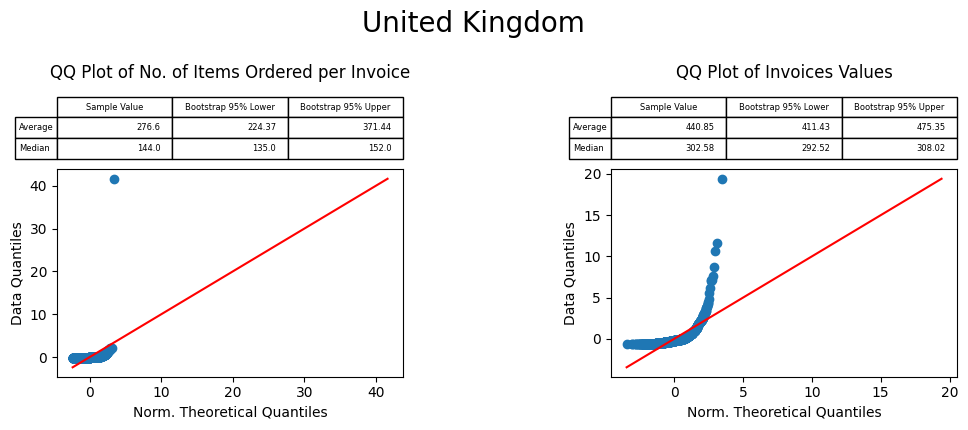

In [74]:
QQplots_and_CI(UK_sample_items, UK_sample_value, UK_Ci, "United Kingdom")

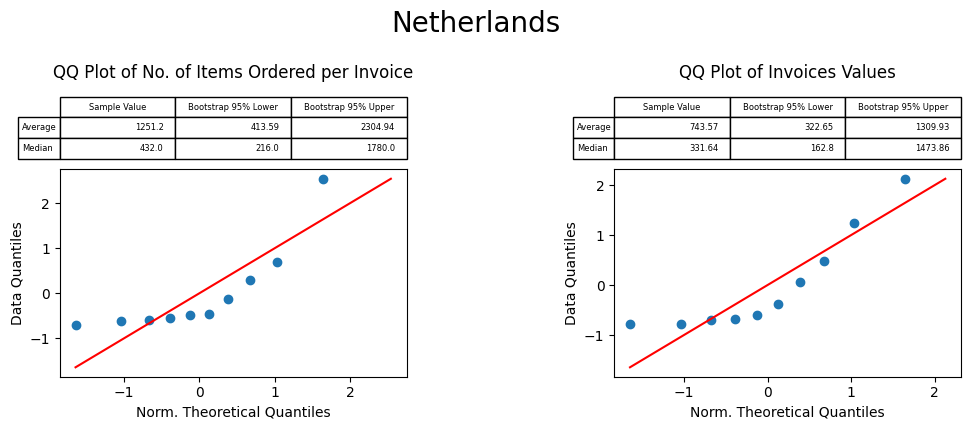

In [69]:
QQplots_and_CI(NE_sample_items, NE_sample_value, NE_Ci, "Netherlands")

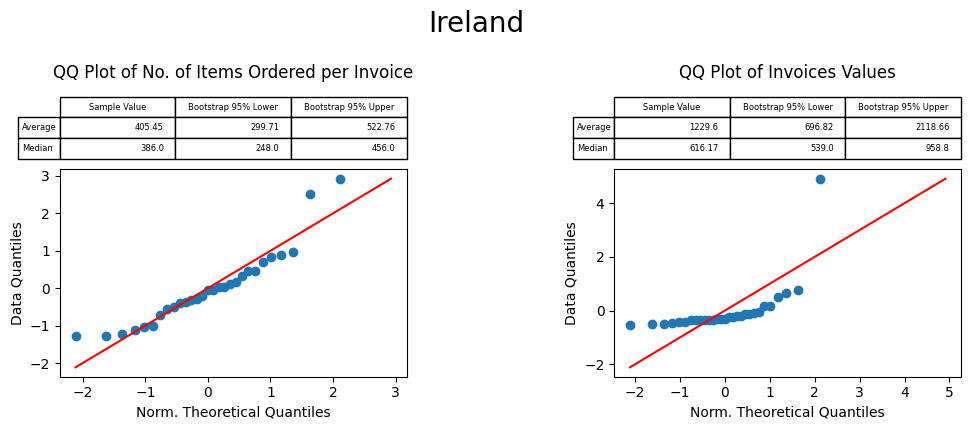

In [70]:
QQplots_and_CI(IR_sample_items, IR_sample_value, IR_Ci, "Ireland")

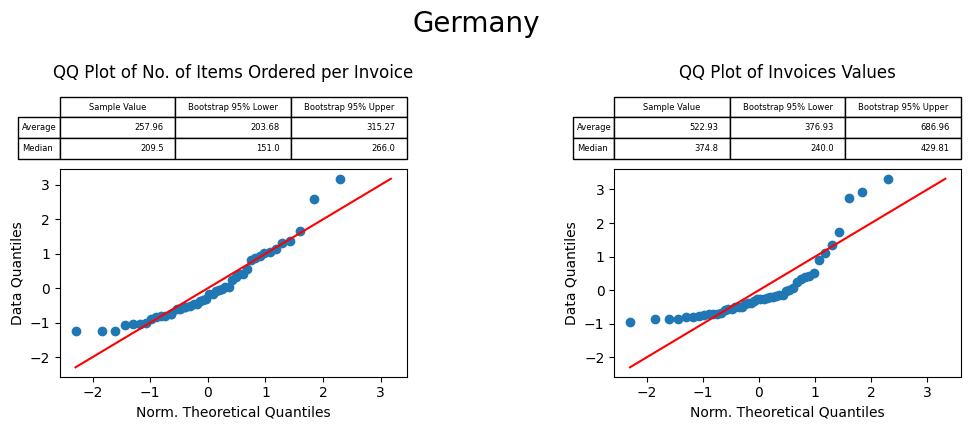

In [71]:
QQplots_and_CI(GER_sample_items, GER_sample_value, GER_Ci, "Germany")

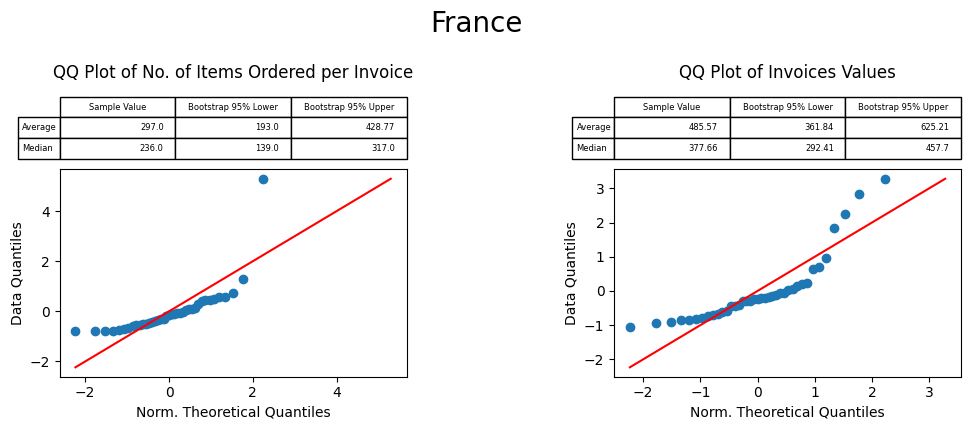

In [72]:
QQplots_and_CI(FR_sample_items, FR_sample_value, FR_Ci, "France")